# United Nations General Assembly Resolutions
## Analysis with Unsupervised Machine Learning

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from collections import Counter


dirname=os.path.dirname

ROOT_DIR = os.path.join('..', '..')
INIT_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'initial')
INTER_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'inter')
FINAL_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'final')
ERROR_LOG = os.path.join(ROOT_DIR, 'error-logs')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'output', 'unsupervised')

plt.style.use("seaborn")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 300

### Loading Data

In [2]:
md = pd.read_json(os.path.join(FINAL_DATA_PATH, 'metadata.json'))
md['Vote date'] = pd.to_datetime(md['Vote date'])
votes = pd.read_json(os.path.join(FINAL_DATA_PATH, 'votes.json'))

In [3]:
era_names = ['Early Cold War (1946-1960)', 'Transitional Period (1971-1990)', 'Post-Cold War (1991-2022)']

eras = votes.merge(md[['Resolution', 'Vote date']], right_on='Resolution', left_index=True, how='inner')
eras['year'] = pd.DatetimeIndex(eras.pop('Vote date')).year.astype(int)

def get_era(year): 
    if year <= 1960:
        return era_names[0]
    if year <= 1990: 
        return era_names[1]
    return era_names[2]

eras['era'] = eras.pop('year').apply(get_era)
eras.set_index('Resolution', inplace=True)

era_list = [era[1].drop(['era'], axis=1) for era in list(eras.groupby('era'))]
era_list.append(era_list.pop(1))

In [4]:
def transform_votes(df): 
    vote_dict = {
        'Y': 1,
        'N': -1,
        'A': 0,
        'X': 0
    }

    votes_t = df.dropna(axis=1, thresh=df.shape[0] * .5).T
    for res in votes_t.columns: 
        votes_t[res] = votes_t[res].map(vote_dict)
    votes_t.fillna(0, inplace=True)
    return votes_t

In [5]:
ecw, tp, pcw = list(map(transform_votes, era_list))

### Early Cold War (1946-1960)

#### Dimensionality Reduction with PCA

<Figure size 300x450 with 0 Axes>

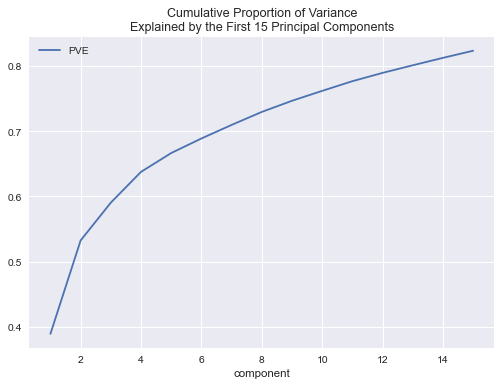

In [6]:
pca = PCA(random_state=1, svd_solver='full', n_components=15)
components = pca.fit_transform(ecw)

pca_df = pd.DataFrame(list(zip(range(15), pca.explained_variance_ratio_[:15])), columns=['component', 'PVE'])
pca_df['PVE'] = pca_df.PVE.cumsum()
pca_df['component'] += 1
plt.figure(figsize = (4, 6));
pca_df.plot(kind='line', x='component', y='PVE');
plt.title('Cumulative Proportion of Variance\nExplained by the First 15 Principal Components')
plt.savefig(os.path.join(OUTPUT_PATH, 'pve_country_ecw.png'))
plt.show()

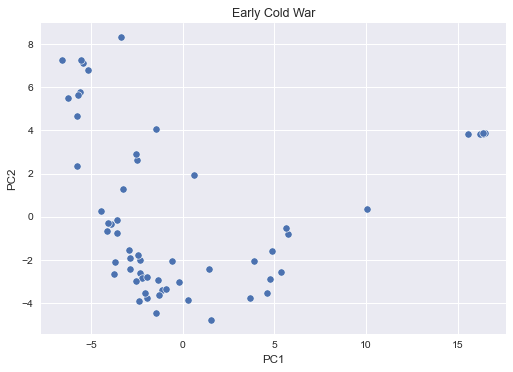

In [7]:
pca_df = pd.DataFrame(components[:, :3], columns=['PC1', 'PC2', 'PC3'], index=ecw.index)
sns.scatterplot(data=pca_df, x='PC1', y='PC2').set(title='Early Cold War')
plt.show()

#### Dimensionality Reduction with t-SNE and Agglomerative Clustering

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dend = dendrogram(linkage_matrix, **kwargs)
    return dend

/Users/egemenpamukcu/Desktop/course-materials/thesis/unga-resolutions/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


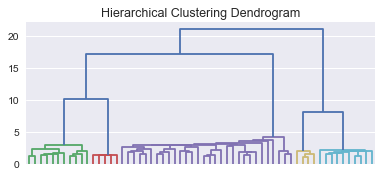

In [9]:
ecw_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='pca', perplexity=5, random_state=1).fit_transform(ecw)

model = AgglomerativeClustering(n_clusters=5, linkage='single', compute_distances=True)
clusters = model.fit_predict(ecw_embedded)

plt.figure(figsize = (6,2.5));
plt.title("Hierarchical Clustering Dendrogram")
dend = plot_dendrogram(model, color_threshold=5, no_labels=True)
plt.savefig(os.path.join(OUTPUT_PATH, 'dendogram_ecw.png'))
plt.show()

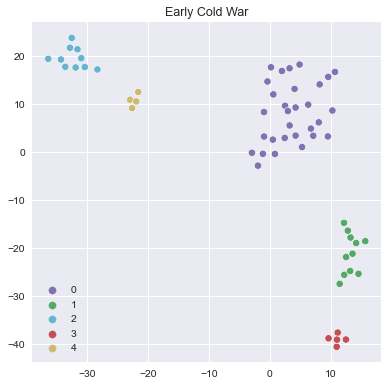

In [10]:
dend_colors = {v+1:k for k, v in Counter(dend['color_list']).items() if k!='C0'}
cluster_colors = {k: dend_colors[v] for k, v in Counter(clusters).items()}

plt.figure(figsize = (6,6));
sns.scatterplot(x=ecw_embedded[:, 0], y=ecw_embedded[:, 1], hue=clusters, palette=cluster_colors).set(title='Early Cold War')
plt.savefig(os.path.join(OUTPUT_PATH, 'clusters_ecw.png'))
plt.show()

In [11]:
all_clusters = []
all_clusters += list(zip([0] * len(clusters), clusters, ecw.index))

### Transitional Period (1971-1990)

#### Dimensionality Reduction with PCA

<Figure size 300x450 with 0 Axes>

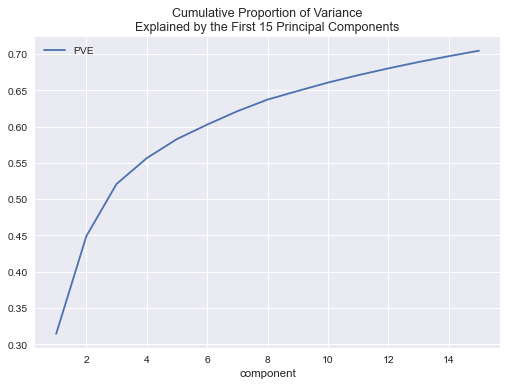

In [12]:
pca = PCA(random_state=1, svd_solver='full', n_components=15)
components = pca.fit_transform(tp)

pca_df = pd.DataFrame(list(zip(range(15), pca.explained_variance_ratio_[:15])), columns=['component', 'PVE'])
pca_df['PVE'] = pca_df.PVE.cumsum()
pca_df['component'] += 1
plt.figure(figsize = (4, 6));
pca_df.plot(kind='line', x='component', y='PVE');
plt.title('Cumulative Proportion of Variance\nExplained by the First 15 Principal Components')
plt.savefig(os.path.join(OUTPUT_PATH, 'pve_country_tp.png'))
plt.show()

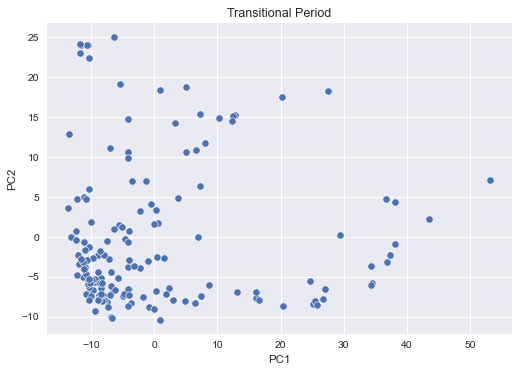

In [13]:
pca_df = pd.DataFrame(components[:, :3], columns=['PC1', 'PC2', 'PC3'], index=tp.index)
sns.scatterplot(data=pca_df, x='PC1', y='PC2').set(title='Transitional Period')
plt.show()

#### Dimensionality Reduction with t-SNE and Agglomerative Clustering

/Users/egemenpamukcu/Desktop/course-materials/thesis/unga-resolutions/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


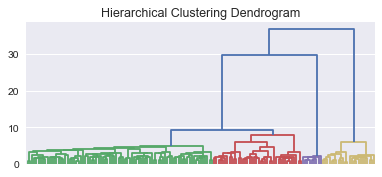

In [14]:
tp_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='pca', perplexity=5, random_state=1).fit_transform(tp)

model = AgglomerativeClustering(n_clusters=4, linkage='single', compute_distances=True)
clusters = model.fit_predict(tp_embedded)

plt.figure(figsize = (6,2.5));
plt.title("Hierarchical Clustering Dendrogram")
dend = plot_dendrogram(model, color_threshold=8, no_labels=True)
plt.savefig(os.path.join(OUTPUT_PATH, 'dendogram_tp.png'))
plt.show()

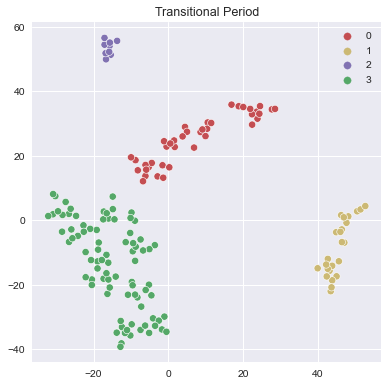

In [15]:
dend_colors = {v+1:k for k, v in Counter(dend['color_list']).items() if k!='C0'}
cluster_colors = {k: dend_colors[v] for k, v in Counter(clusters).items()}

plt.figure(figsize = (6,6));
sns.scatterplot(x=tp_embedded[:, 0], y=tp_embedded[:, 1], hue=clusters, palette=cluster_colors).set(title='Transitional Period')
plt.savefig(os.path.join(OUTPUT_PATH, 'clusters_tp.png'))
plt.show()

In [16]:
all_clusters += list(zip([1] * len(clusters), clusters, tp.index))

## Post-Cold War (1991-2022)

#### Dimensionality Reduction with PCA

<Figure size 300x450 with 0 Axes>

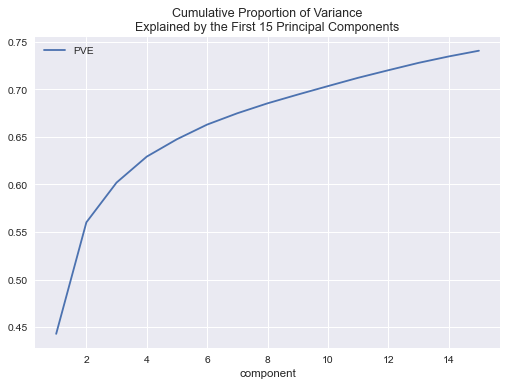

In [17]:
pca = PCA(random_state=1, svd_solver='full', n_components=15)
components = pca.fit_transform(pcw)

pca_df = pd.DataFrame(list(zip(range(15), pca.explained_variance_ratio_[:15])), columns=['component', 'PVE'])
pca_df['PVE'] = pca_df.PVE.cumsum()
pca_df['component'] += 1
plt.figure(figsize = (4, 6));
pca_df.plot(kind='line', x='component', y='PVE');
plt.title('Cumulative Proportion of Variance\nExplained by the First 15 Principal Components')
plt.savefig(os.path.join(OUTPUT_PATH, 'pve_country_pcw.png'))
plt.show()

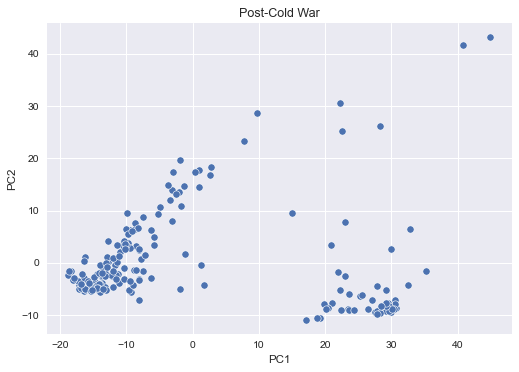

In [18]:
pca_df = pd.DataFrame(components[:, :3], columns=['PC1', 'PC2', 'PC3'], index=pcw.index)
sns.scatterplot(data=pca_df, x='PC1', y='PC2').set(title='Post-Cold War')
plt.show()

#### Dimensionality Reduction with t-SNE and Agglomerative Clustering

/Users/egemenpamukcu/Desktop/course-materials/thesis/unga-resolutions/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


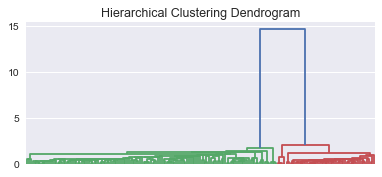

In [19]:
pcw_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='pca', perplexity=40, random_state=1).fit_transform(pcw)

model = AgglomerativeClustering(n_clusters=2, linkage='single', compute_distances=True)
clusters = model.fit_predict(pcw_embedded)

plt.figure(figsize = (6,2.5));
plt.title("Hierarchical Clustering Dendrogram")
dend = plot_dendrogram(model, color_threshold=8, no_labels=True)
plt.savefig(os.path.join(OUTPUT_PATH, 'dendogram_pcw.png'))
plt.show()

/Users/egemenpamukcu/Desktop/course-materials/thesis/unga-resolutions/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


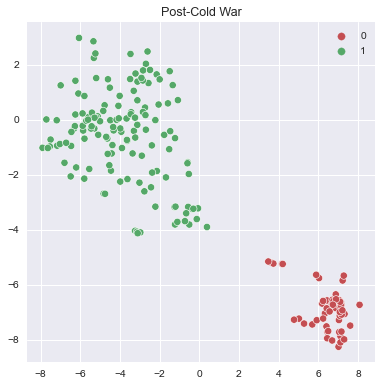

In [20]:
dend_colors = {v+1:k for k, v in Counter(dend['color_list']).items() if k!='C0'}
cluster_colors = {k: dend_colors[v] for k, v in Counter(clusters).items()}

pcw_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='pca', perplexity=50, random_state=1).fit_transform(pcw)

plt.figure(figsize = (6,6));
sns.scatterplot(x=pcw_embedded[:, 0], y=pcw_embedded[:, 1], hue=clusters, palette=cluster_colors).set(title='Post-Cold War')
plt.savefig(os.path.join(OUTPUT_PATH, 'clusters_pcw.png'))
plt.show()

In [21]:
all_clusters += list(zip([2] * len(clusters), clusters, pcw.index))

### Save Cluster Information

In [26]:
all_clusters_df = pd.DataFrame(all_clusters, columns=['era', 'cluster', 'country'])
all_clusters_df.sort_values(['era', 'cluster', 'country'], inplace=True)
all_clusters_df.to_csv(os.path.join(OUTPUT_PATH, 'clusters.csv'), index=False)
all_clusters_df.sample(n=10, random_state=1)

,era,cluster,country
325,2,1,MAURITIUS
142,1,3,MADAGASCAR
400,2,0,UNITED STATES
241,2,1,BRUNEI DARUSSALAM
147,1,0,MALTA
165,1,0,PAPUA NEW GUINEA
76,1,0,BHUTAN
55,0,0,VENEZUELA
321,2,1,MALI
296,2,1,IRAQ
